# Gradient descent for logistic regression
In this notebook, I implement a method for performing gradient descent to estimate the parameters for a logistic regression model using [cross entropy (log loss)](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) as the loss function.

This implementation performs binary classification, where the target is either `0` or `1`.

Author: [Ryan Parker](https://github.com/rparkr)

# Setup: library imports

In [1]:
import time  # measure code execution

from IPython.display import clear_output  # create simple animations using multiple Matplotlib plots
import matplotlib as mpl  # lower-level plotting functionality
import matplotlib.pyplot as plt  # general purpose plotting
import numpy as np  # numerical computation on arrays
from sklearn.datasets import make_classification  # dataset generation

# Logistic (sigmoid) function
Logistic regression fits a model where the output—a float between 0 and 1—represents the probability that an input belongs to the target class (`1`, since this is binary classification). Once the model is trained, an input can be classified using a threshold value, or _decision boundary_, like 0.5 (if the predicted probability is ≥0.5, then the input will be classified as `1`, else `0`.)

To return a probability, the model passes the output, $z$, of linear regression ($z = w \cdot x + b$) as the input to the logistic function. The output from the logistic function is the predicted probability of the target class. Thus:

**Linear regression:**  
$$z = w \cdot x + b$$

**Logistic function:**
$$\hat{p} = \frac{1}{1 + e^{-z}}$$

where
- $w$ is the weight array, shape (n,)
- $x$ is the input array, shape (m, n) (_m_ samples by _n_ features)
- $b$ is the bias (scalar)
- $\hat{p}$ is the predicted probability of the target class (that is, the probability that the input has a class of `1`)

Here's how to implement those functions in code:

In [2]:
def linear(x_input, weights, bias):
    '''Predict an output given an input, weights, and a bias term (intercept).
    Uses the calculation: z = W • x + b.

    Parameters
    ----------
    x_input: np.ndarray of shape (m_samples, n_features)
        Inputs to the linear regression model.
    weights: array of shape (n_features,)
        The coefficients for the input features.
    bias: float
        An adjustment factor, the `b` in y = wx + b.
    
    Returns
    -------
    z: np.ndarray of shape (m_samples,)
        The predicted outputs.
    '''
    z = np.dot(x_input, weights) + bias
    return z


def sigmoid(z) -> float:
    '''Calculate the probability that an input is the target class by passing
    z into the logistic (sigmoid) function and returning the result.

    Parameters
    ----------
    z: np.ndarray of shape (m_samples,)
        The output of a linear regression model.

    Returns
    -------
    float in the range (0.0, 1.0)
    '''
    return 1 / (1 + np.exp(-z))


...of course, the functions could be combined, like this:

In [3]:
def predict_probs(x_input, weights, bias):
    '''Predict the probability of the target class using logistic regression.'''
    z = np.dot(x_input, weights) + bias
    return 1 / (1 + np.exp(-z))


# Gradient descent algorithm
This implementation uses the partial derivatives of:
- the weight vector $w$
- the bias $b$

with respect to the cost function (the average of cross entropy, or log loss), which is defined as:

$$cost = -\frac{1}{m} \sum_{i=0}^{m} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$$

where:
- $m$ = the number of training samples
- $y_i$ = the target for a sample: a binary value of `0` or `1`
- $\hat{y}_i$ = the model's prediction using the sigmoid function: $\frac{1}{1 + e^{-z}}$, where:
  - $z$ = $w \cdot x + b$
  - $w$ = the weight vector, or the coefficients of each of the features (input columns)
  - $x$ = the input array (_m_ samples by _n_ features)
  - $b$ = the bias term (scalar)

The partial derivates of the cost function (above) are:

**Partial derivative of the cost function $f$ with respect to the weights $w$:**  
$$\frac{\partial f}{\partial w} = \frac{1}{m}  \sum_{i=0}^{m} (\hat{y}_i - y_i) \  x_i $$

**Partial derivative of the cost function $f$ with respect to the bias $b$:**  
$$\frac{\partial f}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m} (\hat{y}_i - y_i)$$

Note that those are the same partial derivatives for the cost function in linear regression—the difference is $\hat{y}_i$, which uses the logistic function in this case rather than the linear function.

In the cell below, I implement those functions using vectorized operations in NumPy.

In [4]:
def compute_cost(x_input, y_target, weights, bias):
    '''Return the average loss using cross entropy (log loss) based on an 
    input, target, weights, and bias.
    
    Parameters:
    ----------
    x_input: array of shape (m_samples, n_features)
        Inputs to the logistic regression model.
    y_target: array of shape (m_samples,)
        The targets to predict (binary: 0 or 1).
    weights: array of shape (n_features,)
        The coefficients for the input features.
    bias: float
        An adjustment factor, the _b_ in y = wx + b.

    Returns:
    -------
    cost: float
        A measure of the average distance between predicted and target values.
    '''
    num_samples = x_input.shape[0]
    # Step-by-step version:
    # z = linear(x_input, weights, bias)
    # y_hat = sigmoid(z)
    # All in one:
    y_hat = predict_probs(x_input, weights, bias)
    cost = -np.sum(
          (y_target * np.log(y_hat))
        + ((1 - y_target) * np.log(1 - y_hat))
    ) / num_samples
    return cost


def gradient_descent(x_input, y_target, weights, bias, alpha=0.01):
    '''Compute the gradient and take a step in the negative gradient (scaled by alpha).
    
    Parameters:
    ----------
    x_input: array of shape (m_samples, n_features)
        Inputs to the logistic regression model.
    y_target: array of shape (m_samples,)
        The targets to predict.
    weights: array of shape (n_features,)
        The coefficients for the input features.
    bias: float
        An adjustment factor, the `b` in y = wx + b.
    alpha: float, default = 0.01
        The learning rate that scales the parameter update step
        for the gradient descent.
    
    Returns:
    -------
    (weights, bias) tuple with the new weights and bias after taking a step
    in the direction of the negative gradient.
    '''
    num_samples = x_input.shape[0]
    y_hat = predict_probs(
        x_input, weights, bias)
    error = y_hat - y_target  # shape: (m_samples,)
    # These are the gradients (derivative of function F with respect to weights W or bias B)
    # I transpose (.T) the x_input array to have shape (n_features, m_samples)
    # so it produces an output of shape (n_features,) after a dot product with the error.
    df_dw = (1 / num_samples) * np.dot(x_input.T, error)
    df_db = (1 / num_samples) * np.sum(error)
    new_w = weights - (alpha * df_dw)
    new_b = bias - (alpha * df_db)
    return new_w, new_b

# Sample data set

Input shape: (1000, 2)
Target shape: (1000,)


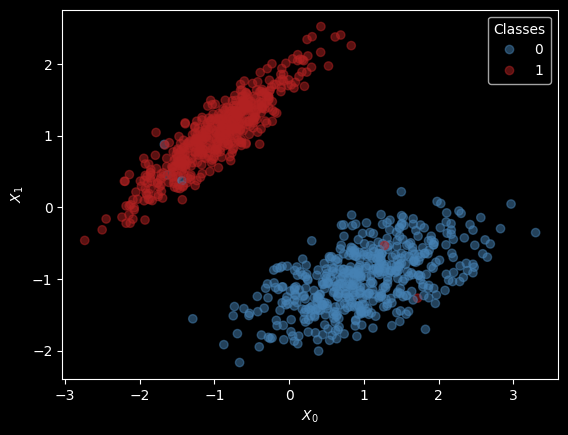

In [5]:
# Create arrays for the inputs (X) and target (y)
X, y = make_classification(
    n_samples=1_000, 
    n_classes=2, 
    n_features=2,  # total number of features
    n_informative=2,
    n_redundant=0, 
    n_repeated=0, 
    n_clusters_per_class=1,
    class_sep=1.0  # larger values create clusters farther apart
)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")
# Either plot all at once:
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=mpl.colors.ListedColormap(['steelblue', 'firebrick']), alpha=0.5)
legend1 = plt.legend(*scatter.legend_elements(), title='Classes')  # Reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html

# Or, loop through each class label
# for n, color in zip(np.unique(y), ['steelblue', 'firebrick']):
#     plt.scatter(X[y==n, 0], X[y==n, 1], alpha=0.5, label=n, c=color)
# plt.legend(title='Classes')

plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()

# Optimization
Optimize a linear regression function through gradient descent.

In [6]:
# Initialize the weights and bias values
rng = np.random.default_rng(seed=0)
weights = rng.random(size=X.shape[1])
bias = rng.random()

# Set the learning rate
alpha = 0.1

num_steps = 10_000
num_chars = len(f"{num_steps:,.0f}")  # for aligning text when printed
early_stopping_threshold = 0.0000001  # end training if loss improves by less than this amount
loss_history = [compute_cost(X, y, weights, bias)]
params_history = [(weights, bias, 0)]  # (weights, bias, step)

start_time = time.perf_counter()
for step in range(num_steps):
    weights, bias = gradient_descent(X, y, weights, bias, alpha)
    loss = compute_cost(X, y, weights, bias)
    if loss_history[-1] - loss < early_stopping_threshold:
        print(f"Early stopping at step {step + 1:,.0f}/{num_steps:,.0f}")
        print(f"loss = {loss:,.5f}")
        # Capture the final parameters in the case of early stopping
        params_history.append((weights, bias, step + 1))
        break
    loss_history.append(loss)
    # Track and display progress 10 times during training
    if (step + 1) % (num_steps // 10) == 0:
        params_history.append((weights, bias, step + 1))
        print(
            f"step {step + 1:{num_chars},.0f}/{num_steps:,.0f}"
            f" | loss = {loss:,.5f}"
        )

# Show how well the model fit the dataset
print('=' * 50)
print(f"Estimated parameters:\n{weights.round(3)}")
print(f"Estimated bias: {bias:.3f}")
print('-' * 50)
end_time = time.perf_counter() - start_time
if end_time // 60 > 0:
    print(f"Run time: {end_time // 60:,.0f}m {end_time % 60:.1f}s")
else:
    print(f"Run time: {end_time % 60:.1f}s")

step  1,000/10,000 | loss = 0.03669
step  2,000/10,000 | loss = 0.03523
step  3,000/10,000 | loss = 0.03482
step  4,000/10,000 | loss = 0.03464
Early stopping at step 4,342/10,000
loss = 0.03461
Estimated parameters:
[-1.922  3.724]
Estimated bias: -0.360
--------------------------------------------------
Run time: 1.6s


# Classify inputs
The binary logistic regression model outputs probabilities (a float between 0 and 1) that a given input belongs to the target class. The `classify()` function uses a probability threshold called the _decision boundary_ to classify the model's predictions: outputs above that threshold will be classified as `1` and outputs below that threshold will be classified as `0`. A standard selection for the decision boundary is `0.5`: outputs with at least 50% probability will be classified as `1`.

In [7]:
def classify(x_input, weights, bias, threshold=0.5):
    '''Classify binary inputs using a logistic regression model.

    Parameters
    ----------
    x_input: array of shape (m_samples, n_features)
        Inputs to the logistic regression model.
    weights: array of shape (n_features,)
        The coefficients for the input features.
    bias: float
        An adjustment factor, the `b` in y = wx + b.
    threshold: float in the range (0.0, 1.0), default=0.5
        The probability threshold for classifying inputs.
        Outputs above this value will be classified as `1`,
        below this value as `0`.

    Returns
    -------
    labels: np.ndarray of shape (m_samples,)
        The predicted class for each input sample.
    '''
    label_probs = predict_probs(x_input, weights, bias)
    # Fill an array with zeros
    labels = np.zeros_like(label_probs)
    # Classify targets
    labels[label_probs >= threshold] = 1
    return labels
   

# Accuracy
There are many measures of performance for a classification model (e.g., precision, recall, f1 score). In this section, I compute a simple measure: average accuracy across samples.

In [8]:
def compute_accuracy(x_input, y_target, weights, bias, threshold=0.5):
    '''Calculate the average percentage of correct predictions.
    
    Parameters:
    ----------
    x_input: array of shape (m_samples, n_features)
        Inputs to the model.
    y_target: array of shape (m_samples,)
        The targets to predict.
    weights: array of shape (n_features,)
        The coefficients for the input features.
    bias: float
        An adjustment factor, the `b` in y = wx + b.
    threshold: float in the range (0.0, 1.0), default=0.5
        The probability threshold for classifying inputs.
        Outputs above this value will be classified as `1`,
        below this value as `0`.
    
    Returns:
    -------
    acc: float
        The percentage of correct predictions, that is, num_correct / num_samples
    '''
    labels = classify(x_input, weights, bias, threshold)
    num_samples = y_target.shape[0]
    num_correct = np.sum(labels == y_target)
    return num_correct / num_samples


## What input leads to a given probability?
Recall that the logistic regression function uses sigmoid with an input, $y$, of a linear model ($y = wx +b$). The decision boundary uses a threshold that is the output of the logistic regression function: a probability between 0 and 1. To plot decision boundaries, we need to know what input $y$ will lead to a given probability when passed through the sigmoid function.

Here's how to solve for that:  
let $g$ be the probability output from the sigmoid function, $g = \frac{1}{1+e^{-y}}$, and $y$ be the output from a linear function, $y = w \cdot x + b$, then:
1. multiply both sides by $(1+e^{-y})$: $$g(1+e^{-y}) = 1$$
2. divide both sides by $g$: $$(1+e^{-y}) = \frac{1}{g}$$
3. subtract $1$ from both sides: $$e^{-y} = \frac{1}{g} - 1$$
4. take the logarithm of both sides: $$\log(e^{-y}) = \log(\frac{1}{g} - 1)$$
5. ...which equals: $$-y = \log(\frac{1}{g} - 1)$$
6. multiply both sides by $-1$: $$y = -\log(\frac{1}{g} - 1)$$

The `get_input()` function below implements those steps in code, returning the $y$ value that leads to a given probability output from the sigmoid function.

In [9]:
def get_input(probability_value):
    '''Return a number that, when passed to the sigmoid function, equals the given `probability_value`.

    Let "g" be the probability_value output by the sigmoid function, then:
    Sigmoid function: g = 1 / (1 + e^-y)
    Solve for y:
        y = -log(1/g - 1)
    
    Parameters
    ----------
    probability_value: {np.array, float}
        The probability output by the sigmoid function.

    Returns
    -------
    y: {np.array, float} of same shape as probability_value
        The value(s) that, when passed to sigmoid, returns
        the given probability_value
    
    Notes
    -----
    This function can be used to plot decision boundaries. For a given decision boundary threshold
    (the probability_value input to this function), this function will return the input needed to
    produce that probability. One can then solve for the input using the standard linear equation
    (y = wx + b) to plot the decision boundary. For example, in the case of two input variables,
    x0 and x1, one could solve for x1 to plot the decision boundary line between x0 and x1, like this:
        y = w0x0 + w1x1 + b

        w1x1 = y - w0x0 - b

        x1 = (y - w0x0 - b) / w1

        `import matplotlib.pyplot as plot`

        `plt.plot(x0, x1)`

    '''
    return -np.log((1 / probability_value) - 1)


print(f"The sigmoid function outputs a probability of 0.5 at x=0.")
print(f">>> get_input(0.5)\n{get_input(0.5)}\nExpected result: 0")

print('\nWorks for multiple inputs as well:')
probs = np.array([0.01, 0.25, 0.5, 0.75, 0.99])
print("Probability values:")
print(probs)
print("Input values:")
inputs = get_input(probs)
print(inputs.round(2))

The sigmoid function outputs a probability of 0.5 at x=0.
>>> get_input(0.5)
-0.0
Expected result: 0

Works for multiple inputs as well:
Probability values:
[0.01 0.25 0.5  0.75 0.99]
Input values:
[-4.6 -1.1 -0.   1.1  4.6]


# Visualize training and model fit

## Plot results
The cell below plots a decision boundary between two input variables ($X_0$ and $X_1$), with the true and predicted classes.

The model's final predictions:


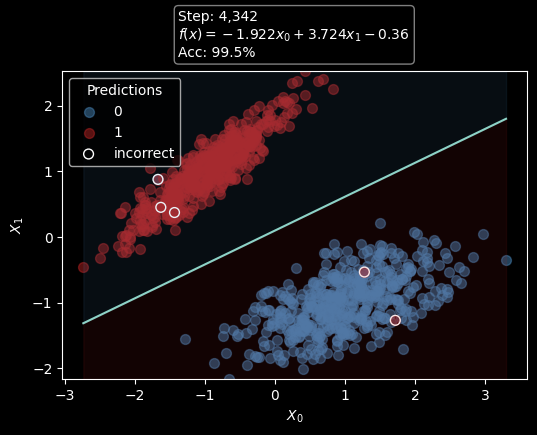

In [10]:
def plot_decision_boundary(X, y, w, b, step, threshold=0.5):
    """Generate a plot showing the predicted classes and the decision boundary.
    For visualizing, this uses only the first two features in X.

    Parameters
    ----------
    X : np.ndarray of shape (m_samples, n_features)
        The input data.
    y : np.ndarray of shape (m_samples,)
        The target labels (binary)
    w : np.ndarray of shape (n_features,)
        The weights used on model parameters.
    b : float
        The model's bias parameter (the "b" in y = wx + b)
    step : int
        The gradient descent step at which the weights and bias
        were computed.
    threshold : float in the range (0, 1), default=0.5
        Sets the decision boundary: predictions with a 
        probability >= threshold will be classified as 1 (the target),
        otherwise, they will be classified as 0.


    Return value
    ------------
    `None`
    """

    fig, ax = plt.subplots(figsize=(6, 4))

    # Get the weights and bias from final parameter update
    w = np.array(w)[:2]  # Limit to the first two dimensions
    labels = classify(x_input=X[:, :2], weights=w, bias=b)

    # Plot target values
    for n, color in zip(np.unique(y), ['steelblue', 'firebrick']):
        ax.scatter(X[y==n, 0], X[y==n, 1], alpha=0.5, label=n, s=50, c=color)

    # Plot incorrect predictions
    mask_incorrect = (labels != y)
    ax.scatter(X[mask_incorrect, 0], X[mask_incorrect, 1], label='incorrect', edgecolor='white', s=50, facecolors='none')

    # Plot decision boundary, with shading
    xlims = np.min(X[:, 0]), np.max(X[:, 0])  # x axis is the x0 variable
    ylims = np.min(X[:, 1]), np.max(X[:, 1])  # y axis is the x10 variable
    # The boundary line is calculated as y = w0x0 + w1x1 + b and solved for x1,
    # where y is sigmoid(threshold), and x1 = (y - w0x0 - b) / w1
    xvals = np.linspace(xlims[0], xlims[1], 10)  # Evenly spaced points for the boundary line
    input_val = get_input(threshold)
    boundary = (input_val - (w[0] * xvals) - b) / w[1]  # boundary line y values (in this case, x1 values)
    ax.plot(xvals, boundary)
    # Use the ylims after plotting the boundary line, since they might extend 
    # beyond the data points (i.e., x1) if the line is poorly fit.
    ax.set_ylim(ylims[0], ylims[1])

    # Shade the area where predictions = 0
    # If the w[0] parameter is positive, this line will have a negative slope,
    # so the *bottom* half needs to be shaded blue. If the w[0] parameter is
    # negative, this line will have a positive slope, so the *top* half needs
    # to be shaded blue. See the equation for "boundary" above to see why that
    # is: the (w[0] * xvals) is subtracted (i.e., multiplied by -1), hence the 
    # slope in opposite direction of the sign of w[0])
    ax.fill_between(
        x=xvals,
        y1=boundary,
        y2=ylims[1] if w[0] < 0 else ylims[0],
        alpha=0.1,
        color='steelblue')
    # Shade the area where predictions = 1
    ax.fill_between(
        x=xvals,
        y1=boundary,
        y2=ylims[0] if w[0] < 0 else ylims[1],
        alpha=0.1,
        color='firebrick')
    
    # Compute the accuracy and add a textbox with metrics
    # see: https://matplotlib.org/stable/gallery/text_labels_and_annotations/placing_text_boxes.html)
    acc = compute_accuracy(X, y, w, b, threshold)
    textstr = '\n'.join((
        f"Step: {step:,.0f}",
        f"$f(x) = {w[0].round(3)}x_0 {'+' if w[1] > 0 else ''}{w[1].round(3)}x_1 {'+' if b > 0 else ''}{np.round(b, 3)}$",
        f"Acc: {acc:.1%}"
    ))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='black', alpha=0.5)

    # place a text box in upper right in axes coords
    ax.text(0.25, 1.2, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # ax.set_title(f"Step: {step:,.0f}")
    ax.set_xlabel('$X_0$')
    ax.set_ylabel('$X_1$')
    ax.legend(title='Predictions')
    plt.show()
    return None


print("The model's final predictions:")
w, b, step = params_history[-1]
plot_decision_boundary(X, y, w, b, step, threshold=0.5)

## Training progress: Animated
The cell below shows a simple animation of the parameter updates during gradient descent.

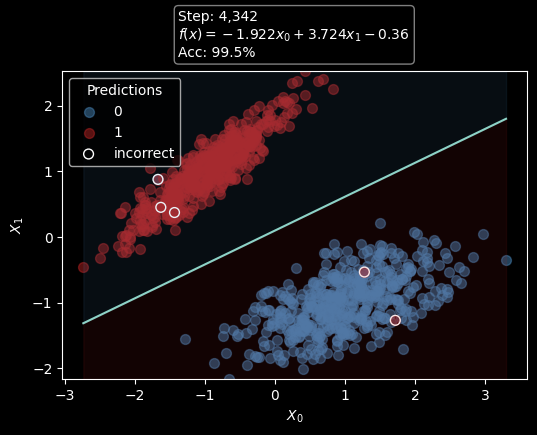

In [11]:
for weights, bias, step in params_history:
    plot_decision_boundary(X, y, weights, bias, step, threshold=0.5)
    # Pause 1 second between refreshes
    time.sleep(1)
    clear_output(wait=True)

## Plot learning curve

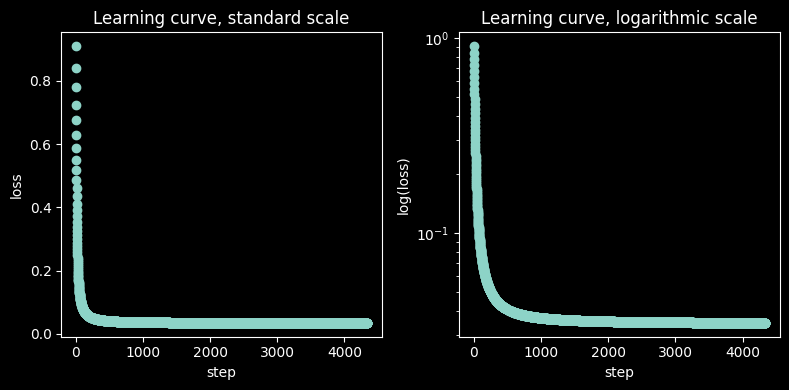

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].scatter(x=list(range(len(loss_history))), y=loss_history)
axs[0].set_ylabel('loss')
axs[0].set_xlabel('step')
axs[0].set_title('Learning curve, standard scale')

axs[1].scatter(x=list(range(len(loss_history))), y=loss_history)
axs[1].set_yscale('log')
axs[1].set_ylabel('log(loss)')
axs[1].set_xlabel('step')
axs[1].set_title('Learning curve, logarithmic scale')

plt.tight_layout()
plt.show()